In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import scipy 
import os
# import seaborn as sns
# import scipy.stats as stats
import unittest

In [2]:
df_battery = pd.read_csv('Battery_Dataset.csv')

In [3]:
import csv
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
from sklearn.model_selection import KFold 
import math

import sklearn
import statistics as stcs
import scipy.stats as stats


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,scale,MinMaxScaler
from scipy.stats import uniform,expon
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

In [4]:
#One hot encoding (alphebetical order)
ohe = OneHotEncoder()
ACE = df_battery.loc[:,['anode','cathode','electrolyte']]
ACE = ohe.fit_transform(ACE)
ACE = pd.DataFrame(ACE.toarray())

ACE_col_name = ['A1','C1','C2','C3','E1','E2','E3']
for i in range(len(ACE.columns)):
    ACE = ACE.rename({ACE.columns[i]: ACE_col_name[i]}, axis=1) 
    
df_battery = pd.concat([ACE, df_battery],axis=1)

In [5]:
data = df_battery

np.random.seed(66)
def data_split (data, test_ratio):
    
    total_row = df_battery.shape[0]
    test_row = round(total_row *test_ratio)
    train_row = total_row - test_row
    
    indices =np.random.permutation(total_row)
    train_indx, test_idx =indices[:train_row], indices[train_row:]
    train,test = df_battery.iloc[train_indx,:], df_battery.iloc[test_idx,:]

    X_test = test[['A1','C1','C2','C3','E1','E2','E3','Cycle','temperature','discharge_crate']]
#    y_test = test[['Charge_Capacity (Ah)']]
    y_test = test[['Discharge_Capacity (Ah)']]
#    y_test = test[['Charge_Energy (Wh)']]
#    y_test = test[['Discharge_Energy (Wh)']]
#    y_test = test[['Coulombic_Efficiency (%)']]
#    y_test = test[['Energy_Efficiency (%)']]
    
    X_train = train[['A1','C1','C2','C3','E1','E2','E3','Cycle','temperature','discharge_crate']]
#    y_train = train[['Charge_Capacity (Ah)']]
    y_train = train[['Discharge_Capacity (Ah)']]
#    y_train = train[['Charge_Energy (Wh)']]
#    y_train = train[['Discharge_Energy (Wh)']]
#    y_train = train[['Coulombic_Efficiency (%)']]
#    y_train = train[['Energy_Efficiency (%)']]
    return train,test,X_train,y_train,X_test,y_test
    
train,test,X_train,y_train,X_test,y_test = data_split(data,0.2)


In [6]:
#k-fold cross validation
kf = KFold(n_splits=10,random_state =66,shuffle= True)
#print(X_test,y_test,X_train,y_train)

In [7]:
clf = StandardScaler(with_mean=True,with_std=True)
print(clf.fit(X_test))
print(clf.mean_)

X_test = pd.DataFrame(clf.transform(X_test))

print(clf.fit(X_train))
print(clf.mean_)
X_train = pd.DataFrame(clf.transform(X_train))

StandardScaler()
[  1.         0.296875   0.34375    0.359375   0.296875   0.359375
   0.34375  292.1875    25.3125     1.4375  ]
StandardScaler()
[1.00000000e+00 3.94531250e-01 2.65625000e-01 3.39843750e-01
 3.94531250e-01 3.39843750e-01 2.65625000e-01 2.70703125e+02
 2.53125000e+01 1.45703125e+00]


In [8]:
np.random.seed(66)

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=66)


train_results =[]
train_results_name =['Experimental','Predicted','RMSE']

for train_index, test_index in kf.split(X_train):
    #print("Train:", train_index, "Validation:", test_index)
    X_training, X_validate = X_train.iloc[train_index], X_train.iloc[test_index]
    y_training, y_validate = y_train.iloc[train_index], y_train.iloc[test_index]
    
    np.random.seed(66)
    gpr.fit(X_training,y_training)
    y_train_predicted = gpr.predict(X_validate)
    
    mse = mean_squared_error(y_train_predicted, y_validate)
    RMSE = np.sqrt(mse)
    
    train_results.append([y_validate,y_train_predicted,RMSE])

In [9]:
Train_results = pd.DataFrame (train_results,columns=train_results_name)

predict_results = pd.DataFrame (Train_results.iloc[:,1])

np.average(Train_results['RMSE'])

0.5726647810271269

In [10]:
np.random.seed(66)
gpr.fit(X_train,y_train)
y_predict = gpr.predict(X_test)

mse = mean_squared_error(y_train_predicted, y_validate)
RMSE = np.sqrt(mse)
RMSE


0.6819793686249375

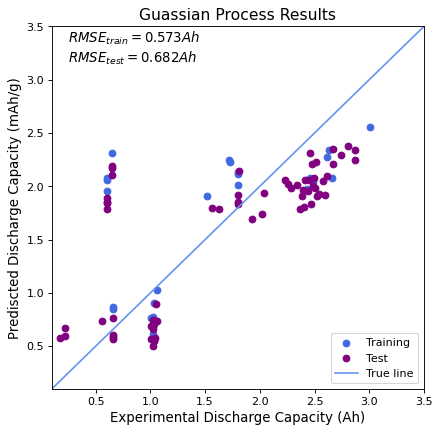

In [15]:
figure(figsize=(6, 6), dpi=80)

plt.axis([0.1,3.5,0.1,3.5])
plt.scatter(x = y_validate, y = y_train_predicted, c='royalblue',label='Training')
plt.scatter(x = y_test, y = y_predict, c='purple',label='Test')
plt.plot([0,5],[0,5],label ='True line',c='cornflowerblue')
plt.legend(loc='lower right')
plt.title(label='Guassian Process Results', fontsize = 14)

plt.xlabel(r'Experimental Discharge Capacity (Ah)', fontsize = 12)
plt.ylabel(r'Prediscted Discharge Capacity (mAh/g)', fontsize = 12)
plt.text(0.25, 3, r'$RMSE_{train}=0.573Ah$'+'\n'+r'$RMSE_{test}=0.682Ah$' +"\n", fontsize = 12)
plt.savefig('GuassianProcess-Predicted-vs-test.png',dpi=600)
plt.show()
